## preparar la base de datos

In [22]:
# código funciona perfectamente
import os
import csv

def cargar_lineas_validas(csv_path, salto=34):
    lineas = []
    with open(csv_path, 'r', encoding='utf-8', errors='ignore') as f:
        for i, line in enumerate(f):
            if i >= salto:
                if line.strip() == "":
                    break
                lineas.append(line.strip())
    return lineas

def encontrar_ruta_componente(archivo, dirs_prioridad):
    for d in dirs_prioridad:
        posible = os.path.join(d, archivo)
        if os.path.exists(posible):
            return posible
    return None

def procesar_vs30(tipo, magnitud, vs30, vs30_path, registros_validos):
    componentes = {
        "H1": os.path.join(vs30_path, "Componente Horizontal 1"),
        "H2": os.path.join(vs30_path, "Componente Horizontal 2"),
        "V":  os.path.join(vs30_path, "Componente Vertical")
    }
    search_csv = os.path.join(vs30_path, "_SearchResults.csv")
    if not os.path.isfile(search_csv):
        print(f"⚠️ No se encuentra el archivo CSV: {search_csv}")
        return 0

    lineas = cargar_lineas_validas(search_csv)
    if not lineas:
        print(f"⚠️ No se encontraron líneas válidas en el CSV: {search_csv}")
        return 0

    validos = 0
    for linea in lineas:
        row = linea.split(",")
        if len(row) < 3:
            continue
        arch_h1, arch_h2, arch_v = row[-3].strip(), row[-2].strip(), row[-1].strip()
        ruta_h1 = encontrar_ruta_componente(arch_h1, [componentes["H1"], componentes["H2"], componentes["V"]])
        ruta_h2 = encontrar_ruta_componente(arch_h2, [componentes["H2"], componentes["H1"]])
        ruta_v  = encontrar_ruta_componente(arch_v,  [componentes["V"],  componentes["H1"], componentes["H2"]])
        
        if ruta_h1 and ruta_h2 and ruta_v:
            validos += 1
            registros_validos.append({
                "Tipo de evento": tipo,
                "Magnitud": magnitud,
                "Vs30": vs30,
                "Archivo H1": arch_h1,
                "Ruta H1": ruta_h1,
                "Archivo H2": arch_h2,
                "Ruta H2": ruta_h2,
                "Archivo V": arch_v,
                "Ruta V": ruta_v
            })
        else:
            print("❌ Faltan archivos:", end=" ")
            if not ruta_h1: print("H1", end=" ")
            if not ruta_h2: print("H2", end=" ")
            if not ruta_v:  print("V",  end=" ")
            print(f"→ en {vs30_path}")
    return validos

def contar_eventos_validos_y_guardar_csv(base_path, tipos_evento, archivo_salida="eventos_validos.csv"):
    total_global = 0
    registros_validos = []

    for tipo in tipos_evento:
        tipo_path = os.path.join(base_path, tipo)
        if not os.path.isdir(tipo_path):
            print(f"❌ No existe la carpeta de tipo: {tipo_path}")
            continue

        for magnitud in os.listdir(tipo_path):
            mag_path = os.path.join(tipo_path, magnitud)
            if not os.path.isdir(mag_path):
                continue

            for vs30 in os.listdir(mag_path):
                vs30_path = os.path.join(mag_path, vs30)
                if not os.path.isdir(vs30_path):
                    continue

                total_local = procesar_vs30(tipo, magnitud, vs30, vs30_path, registros_validos)
                total_global += total_local

                estado = "✅" if total_local > 0 else "⚠️"
                print(f"📁 {tipo} | {magnitud} | {vs30} → {estado} {total_local} eventos válidos")

    # Guardar CSV
    if registros_validos:
        campos = list(registros_validos[0].keys())
        with open(archivo_salida, 'w', newline='', encoding='utf-8') as f:
            writer = csv.DictWriter(f, fieldnames=campos)
            writer.writeheader()
            writer.writerows(registros_validos)
        print(f"\n📄 Archivo CSV generado: {archivo_salida}")
    else:
        print("\n⚠️ No se generó ningún registro válido, no se creó el CSV.")

    return total_global

# Ejecutar
base_dir = os.path.join(os.getcwd(), "Base-sismos-2024")
tipos = ["1 Stiker Slip (SS)", "2 Normal-Oblique", "3 Reverse-Oblique"]
total = contar_eventos_validos_y_guardar_csv(base_dir, tipos)
print("\n🎯 TOTAL GLOBAL de eventos válidos con los tres componentes:", total)


❌ Faltan archivos: V → en /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/Base-sismos-2024/1 Stiker Slip (SS)/Mag. 4-6/Vs30. 200-400
❌ Faltan archivos: V → en /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/Base-sismos-2024/1 Stiker Slip (SS)/Mag. 4-6/Vs30. 200-400
❌ Faltan archivos: V → en /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/Base-sismos-2024/1 Stiker Slip (SS)/Mag. 4-6/Vs30. 200-400
📁 1 Stiker Slip (SS) | Mag. 4-6 | Vs30. 200-400 → ✅ 97 eventos válidos
❌ Faltan archivos: V → en /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/Base-sismos-2024/1 Stiker Slip (SS)/Mag. 4-6/Vs30. 400-600
❌ Faltan archivos: V → en /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/Base-sismos-2024/1 Stiker Slip (SS)/Mag. 4-6/Vs30. 400-600
📁 1 Stiker Slip (SS) | Mag. 4-6 | Vs30. 400-600 → ✅ 98 eventos válidos
📁 1 Stiker Slip (SS) | Mag. 4-6 | Vs30. 0-200 → ✅ 40 eventos válidos
❌ Faltan 

In [23]:
import pandas as pd

In [24]:
df_completo = pd.read_csv('eventos_validos.csv', encoding='utf-8')

In [25]:
# Creación del ID
import pandas as pd
import numpy as np
ph1=df_completo['Archivo H1'].str.split('_').str[:2].str.join('_')
ph2=df_completo['Archivo H2'].str.split('_').str[:2].str.join('_')
phv=df_completo['Archivo V'].str.split('_').str[:2].str.join('_')

mascara = (ph1 == ph2) & (ph1 == phv)
df_completo.loc[mascara, 'Evento ID'] = ph1[mascara]
columnas = ['Evento ID']+ [c for c in df_completo.columns if c != 'Evento ID']
df_completo = df_completo[columnas] #Reordenar, luego esto se lo meteria en el codigo de Andres para que eeste mas clean

#Nose como funciono esto, pero chat ayudo
ocurrencias = df_completo.groupby('Evento ID').cumcount()
mask_segundas = ocurrencias == 1

# 3) Renombra sólo esas filas, añadiendo "_2" al final
df_completo.loc[mask_segundas, 'Evento ID'] = (
    df_completo.loc[mask_segundas, 'Evento ID'] + '_2'
)

df_completo['Evento ID'].nunique()
df_completo.to_csv('eventos_actualizado.csv', index=False) #OJO A LOS NOMBRES DE ARCHIVO


In [26]:
# Creo que tiene ya todo junto
import re

def processNGAfile3(filepath, scalefactor=None):
    """
    Lee un .AT2 y devuelve (npts, dt, time, inp_acc), buscando dinámicamente
    la línea con NPTS= y DT=, y detectando el inicio de los datos numéricos.
    """
    if scalefactor is None:
        scalefactor = 1.0

    with open(filepath, 'r') as f:
        lines = f.readlines()

    # 1) Buscar NPTS y DT en las primeras 20 líneas
    npts = dt = None
    for line in lines[:20]:
        m_n = re.search(r'NPTS\s*=\s*([0-9]+)', line)
        m_d = re.search(r'DT\s*=\s*([0-9]*\.?[0-9]+)', line)
        if m_n: npts = int(m_n.group(1))
        if m_d: dt   = float(m_d.group(1))
        if npts is not None and dt is not None:
            break
    if npts is None or dt is None:
        raise ValueError(f"No se encontró NPTS/DT en {filepath}")

    # 2) Detectar el índice donde empiezan los datos (línea con floats)
    start_idx = None
    num_pattern = re.compile(r'^[-+]?[0-9]*\.?[0-9]+')
    for i, line in enumerate(lines):
        tokens = line.strip().split()
        # si TODOS los tokens tienen formato numérico, asumimos datos
        if tokens and all(num_pattern.match(t) for t in tokens):
            start_idx = i
            break
    if start_idx is None:
        raise ValueError(f"No se encontró inicio de datos en {filepath}")

    # 3) Leer todos los valores desde start_idx en adelante
    acc_data = []
    for line in lines[start_idx:]:
        for tok in line.strip().split():
            acc_data.append(float(tok) * scalefactor)

    inp_acc = np.array(acc_data, dtype=float)
    time    = np.arange(len(acc_data)) * dt

    return npts, dt, time, inp_acc


In [27]:
#Verificacion de que se estan leyendo bien los datos que nos interesan para hacer la normalizacion
import pandas as pd

def agregar_dt_npts(df, comp_cols=('Ruta H1','Ruta H2','Ruta V')):
    """
    A un DataFrame que ya contiene rutas completas en comp_cols,
    le añade dos columnas por componente: NPTS_<sufijo> y DT_<sufijo>.

    Parámetros
    ----------
    df : pd.DataFrame
        Debe tener al menos las columnas indicadas en comp_cols, con la ruta
        completa al archivo .AT2 en cada celda.
    comp_cols : tuple de str
        Nombres de las columnas de df con las rutas para H1, H2 y V.

    Devuelve
    -------
    pd.DataFrame
        Copia de df con las 6 columnas adicionales.
    """
    df2 = df.copy()

    for comp in comp_cols:
        npts_list = []
        dt_list   = []

        # Procesa cada ruta de archivo directamente
        for filepath in df2[comp]:
            # Llama a tu parser robusto:
            npts, dt,_,_ = processNGAfile3(filepath)
            npts_list.append(int(npts))
            dt_list.append(float(dt))

        # Extrae sufijo 'H1','H2' o 'V' a partir del nombre de la columna
        suf = comp.split()[-1]

        # Añade las nuevas columnas
        df2[f'NPTS_{suf}'] = npts_list
        df2[f'DT_{suf}']   = dt_list

    return df2


In [28]:
df_completo=agregar_dt_npts(df_completo,comp_cols=('Ruta H1','Ruta H2','Ruta V'))

In [29]:

# Lista con todos los nuevos nombres, en el orden actual de las columnas
df_completo.columns = ['Evento ID', 'Tipo de evento', 'Magnitud', 'Vs30',
              'Archivo H2', 'Ruta H2', 'Archivo H1', 'Ruta H1',
              'Archivo V', 'Ruta V', 'NPTS_H2', 'DT_H2', 'NPTS_H1', 'DT_H1', 'NPTS_HV', 'DT_HV']

In [30]:
import numpy as np
from scipy.interpolate import interp1d

def normalizar_frecuencia_muestreo(tiempo, aceleracion, dt_obj=0.01):
    t0, t1 = tiempo[0], tiempo[-1]
    t_new   = np.arange(t0, t1, dt_obj)
    f       = interp1d(tiempo, aceleracion,
                       kind='linear',
                       fill_value='extrapolate')
    acc_new = f(t_new)
    return t_new, acc_new

In [31]:

def estandarización(df, comp_cols=('Ruta H1','Ruta H2','Ruta V'),
                          parser=processNGAfile3,
                          dt_obj=0.01):

    for label in ['H1','H2','V']:
        df[f'Acc_{label}_std'] = None
    df['NPTS_common'] = None
    df['DT_common']   = None

    # 2) Recorre cada evento (fila) de df
    for idx, row in df.iterrows():
        remuestreos = {}

        # 2a) Leer y remuestrear
        for label, col in zip(['H1','H2','V'], comp_cols):
            npts, dt, tiempo, acc = parser(row[col])
            # avisar si el dt original no es el esperado
            if abs(dt - dt_obj) > 1e-8:
                print(f"[Aviso] dt original {dt}≠{dt_obj} en fila {idx} / {label}")
            # remuestreo
            _, acc_norm = normalizar_frecuencia_muestreo(tiempo, acc, dt_obj=dt_obj)
            remuestreos[label] = acc_norm

        # 2b) Determinar longitud mínima común
        min_len = min(len(a) for a in remuestreos.values())
        df.at[idx, 'NPTS_common'] = min_len
        df.at[idx, 'DT_common']   = dt_obj

        # 2c) Truncar y guardar en df
        for label in ['H1','H2','V']:
            df.at[idx, f'Acc_{label}_std'] = remuestreos[label][:min_len].tolist()

    return df

In [32]:
df_completo = estandarización(df_completo,
                                           comp_cols=('Ruta H1','Ruta H2','Ruta V'),
                                           parser=processNGAfile3,dt_obj=0.01)



[Aviso] dt original 0.005≠0.01 en fila 0 / H1
[Aviso] dt original 0.005≠0.01 en fila 0 / H2
[Aviso] dt original 0.005≠0.01 en fila 0 / V
[Aviso] dt original 0.005≠0.01 en fila 1 / H1
[Aviso] dt original 0.005≠0.01 en fila 1 / H2
[Aviso] dt original 0.005≠0.01 en fila 1 / V
[Aviso] dt original 0.005≠0.01 en fila 2 / H1
[Aviso] dt original 0.005≠0.01 en fila 2 / H2
[Aviso] dt original 0.005≠0.01 en fila 2 / V
[Aviso] dt original 0.005≠0.01 en fila 3 / H1
[Aviso] dt original 0.005≠0.01 en fila 3 / H2
[Aviso] dt original 0.005≠0.01 en fila 3 / V
[Aviso] dt original 0.005≠0.01 en fila 4 / H1
[Aviso] dt original 0.005≠0.01 en fila 4 / H2
[Aviso] dt original 0.005≠0.01 en fila 4 / V
[Aviso] dt original 0.005≠0.01 en fila 5 / H1
[Aviso] dt original 0.005≠0.01 en fila 5 / H2
[Aviso] dt original 0.005≠0.01 en fila 5 / V
[Aviso] dt original 0.005≠0.01 en fila 6 / H1
[Aviso] dt original 0.005≠0.01 en fila 6 / H2
[Aviso] dt original 0.005≠0.01 en fila 6 / V
[Aviso] dt original 0.005≠0.01 en fila 7 

In [33]:
def FFT_featuring(aceleracion): 

    FFT = np.fft.rfft(aceleracion, n=512) 
    magnitud = np.abs(FFT)

    return magnitud

In [34]:
import ast
df_completo['mag_H1'] = df_completo['Acc_H1_std'].apply(lambda x: FFT_featuring(x))
df_completo['mag_H2'] = df_completo['Acc_H2_std'].apply(lambda x: FFT_featuring(x))
df_completo['mag_V']  = df_completo['Acc_V_std'].apply(lambda x: FFT_featuring(x))

# 3. Concatenar las tres magnitudes en una columna de 'features'
df_completo['features_sep'] = df_completo.apply(
    lambda r: np.concatenate([r['mag_H1'], r['mag_H2'], r['mag_V']]),
    axis=1
)

#Mientras respetes la consistencia de segmentos, no “se mezclan” físicamente las componentes: H1 nunca aparece donde va H2, porque tus índices delimitarán qué parte del vector pertenece a cada canal. Entender mejor , tal vez sea importante guardar ese orden?

In [35]:
df_pre = df_completo.copy()
df_pre.drop(columns=[ 'Archivo H2',
       'Ruta H2', 'Archivo H1', 'Ruta H1', 'Archivo V', 'Ruta V', 'NPTS_H2',
       'DT_H2', 'NPTS_H1', 'DT_H1', 'NPTS_HV', 'DT_HV', 'Acc_H1_std',
       'Acc_H2_std', 'Acc_V_std', 'NPTS_common', 'DT_common'], inplace=True)

In [36]:
pip install iterative-stratification



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [37]:
import numpy as np
import pandas as pd
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.preprocessing import OneHotEncoder

In [38]:
# Separar la data
#X_separado = df_precopy[['mag_H1','mag_H2','mag_V']]

X = np.vstack(df_pre['features_sep'].values)  # shape (n_samples, n_feats) #algo esta mal con esto podemos probar despues
y_raw = df_pre[['Tipo de evento','Magnitud','Vs30']]


mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
train_idx, test_idx = next(mskf.split(X, y_raw))
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y_raw.iloc[train_idx], y_raw.iloc[test_idx]

print(f"Training set: {X_train.shape[0]} muestras") 
print(f"Testing set: {X_test.shape[0]} muestras")

Training set: 1357 muestras
Testing set: 339 muestras


In [39]:
# One hot encoding
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

encoder = OneHotEncoder(sparse_output=False) 

y_trainOHE = encoder.fit_transform(y_train)
y_testOHE = encoder.transform(y_test)


In [40]:
import numpy as np
from scipy.interpolate import interp1d

def normalizar_frecuencia_muestreo(tiempo, aceleracion, dt_obj=0.01):
    t0, t1 = tiempo[0], tiempo[-1]
    t_new   = np.arange(t0, t1, dt_obj)
    f       = interp1d(tiempo, aceleracion,
                       kind='linear',
                       fill_value='extrapolate')
    acc_new = f(t_new)
    return t_new, acc_new

In [41]:

def estandarización(df, comp_cols=('Ruta H1','Ruta H2','Ruta V'),
                          parser=processNGAfile3,
                          dt_obj=0.01):

    for label in ['H1','H2','V']:
        df[f'Acc_{label}_std'] = None
    df['NPTS_common'] = None
    df['DT_common']   = None

    # 2) Recorre cada evento (fila) de df
    for idx, row in df.iterrows():
        remuestreos = {}

        # 2a) Leer y remuestrear
        for label, col in zip(['H1','H2','V'], comp_cols):
            npts, dt, tiempo, acc = parser(row[col])
            # avisar si el dt original no es el esperado
            if abs(dt - dt_obj) > 1e-8:
                print(f"[Aviso] dt original {dt}≠{dt_obj} en fila {idx} / {label}")
            # remuestreo
            _, acc_norm = normalizar_frecuencia_muestreo(tiempo, acc, dt_obj=dt_obj)
            remuestreos[label] = acc_norm

        # 2b) Determinar longitud mínima común
        min_len = min(len(a) for a in remuestreos.values())
        df.at[idx, 'NPTS_common'] = min_len
        df.at[idx, 'DT_common']   = dt_obj

        # 2c) Truncar y guardar en df
        for label in ['H1','H2','V']:
            df.at[idx, f'Acc_{label}_std'] = remuestreos[label][:min_len].tolist()

    return df

In [42]:
!pip install lightning
!pip install torchmetrics


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


## RED NEURONAL

In [43]:
import lightning as L
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as T
import numpy as np

class NumpyMultilabelDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.transform:
            # tu pipeline: numpy → FloatTensor
            x = self.transform(x)
        # para BCEWithLogitsLoss necesitamos float en y
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        return x, y

class DataModule(L.LightningDataModule):
    def __init__(self, X_train, y_train, X_val, y_val, X_test, y_test, batch_size = 64): #De la documentación
        super().__init__()
        # Particiones
        self.X_train = X_train
        self.y_train = y_train
        self.X_val =  X_val   
        self.y_val= y_val
        self.X_test  = X_test
        self.y_test =y_test
        self.batch_size = batch_size

        # pipeline de transform: numpy 1D → FloatTensor
        self.transform = T.Compose([
            T.Lambda(lambda x: torch.tensor(x, dtype=torch.float32)),
            # si quisieras centrar/escalar por característica:
            # T.Normalize(mean=[...], std=[...])
        ])

        # metadata para tu modelo
        self.input_shape = X_train.shape[1]
        self.num_classes = y_train.shape[1]

        # placeholders
        self.train_dataset   = None
        self.val_dataset     = None
        self.test_dataset    = None
        self.predict_dataset = None

    def prepare_data(self):
        pass

    def setup(self, stage=None):
        # solo creamos los datasets con lo que ya tienes
        if stage == "fit" or stage is None:
            self.train_dataset = NumpyMultilabelDataset(self.X_train, self.y_train, transform=self.transform)
            self.val_dataset = NumpyMultilabelDataset(self.X_val, self.y_val, transform=self.transform)

        if stage == "test" or stage is None:
            self.test_dataset = NumpyMultilabelDataset(self.X_test, self.y_test, transform=self.transform)

        if stage == "predict" or stage is None:
            # por ejemplo, solo los 5 primeros para demo
            full_test = NumpyMultilabelDataset(self.X_test, self.y_test, transform=self.transform)
            self.predict_dataset = Subset(full_test, range(5))

    def train_dataloader(self):
        return DataLoader(self.train_dataset,batch_size=self.batch_size,shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset,batch_size=self.batch_size,shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_dataset,batch_size=self.batch_size,shuffle=False)

    def predict_dataloader(self):
        return DataLoader(self.predict_dataset,batch_size=self.batch_size,shuffle=False)


In [44]:
!pip install torch-optimizer


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [45]:
import torch
import torch.nn as nn
import pytorch_lightning as L
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import RepeatedKFold
import numpy as np
from torchmetrics.classification import MultilabelF1Score
import pandas as pd
from torch_optimizer import RAdam
from torchmetrics.classification import MultilabelHammingDistance
from torchmetrics.classification import MultilabelAUROC, MultilabelPrecisionRecallCurve
from torchmetrics.classification import (
    MultilabelPrecision,
    MultilabelRecall
)


class Mymodel2(L.LightningModule):
    def __init__(self, input_shape, num_classes, hidden_units, lambda_L2=0.0):
        super().__init__()
        self.hidden_units = hidden_units  # Store the list of hidden units
        layers = []

        for units in hidden_units: #hidden layers
            layers.append(nn.Linear(input_shape, units))
            layers.append(nn.BatchNorm1d(units))
            layers.append(nn.LeakyReLU(negative_slope=0.01)) #Activcion
            layers.append(nn.Dropout(0.3))
            input_shape = units
        layers.append(nn.Linear(input_shape, num_classes))#output layer, logits 9
        self.classifier = nn.Sequential(*layers) #clasificador

        self.lambda_L2 = lambda_L2  # L2 regularization strength
        self.loss = nn.BCEWithLogitsLoss() #Loss function para problemas multilabel

        self.hamming = MultilabelHammingDistance(num_labels=num_classes)
        self.f1_macro = MultilabelF1Score(num_labels=num_classes, average='macro')
    #for inference
    def forward(self, x):
        return self.classifier(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=self.lambda_L2)

    #Que deberia de aumentar en el codigo para poder cumplir con BCEWithLogitsLoss()
    def shared_step(self, batch):
        x, y = batch              # y debe ser un tensor float32 de shape [B, C]
        logits = self(x)          # [B, C]
        loss   = self.loss(logits, y)

        # convertir logits → probabilidades → predicciones binarias
        probs = torch.sigmoid(logits)            # [B, C], en [0,1]
        preds = (probs > 0.5).int()              # umbral 0.5 → {0,1}

        return loss, probs,preds, y
    
    def training_step(self, batch, batch_idx):
        loss, probs, preds, labels= self.shared_step(batch)

        ham = self.hamming(preds, labels.int()) 
        f1ma=self.f1_macro(preds, labels.int())

        self.log('train_loss', loss, logger=True,prog_bar=True)
        self.log('train_ham', ham,  logger=True,prog_bar=True)
        self.log('train_f1ma', f1ma, logger=True,prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, probs, preds, labels= self.shared_step(batch)

        ham = self.hamming(preds, labels.int()) 
        f1ma=self.f1_macro(preds, labels.int())

        self.log('val_loss', loss, on_step=True, on_epoch=True, logger=True,prog_bar=True)
        self.log('val_ham', ham, on_step=True, on_epoch=True, logger=True,prog_bar=True)
        self.log('val_f1ma', f1ma, on_step=True, on_epoch=True, logger=True,prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        loss, probs, preds, labels= self.shared_step(batch)

        ham = self.hamming(preds, labels.int()) 
        f1ma=self.f1_macro(preds, labels.int())

        self.log('test_loss', loss, on_step=True, on_epoch=True, logger=True,prog_bar=True)
        self.log('test_ham', ham, on_step=True, on_epoch=True, logger=True,prog_bar=True)
        self.log('test_f1ma', f1ma, on_step=True, on_epoch=True, logger=True,prog_bar=True)
        return loss
    
    def predict_step(self, batch): #not necessary if dataloader with custom collate for prediction available (see OPTION 3 at the end of the notebook)
        # this calls forward for the inputs only
        inputs, labels = batch
        return self(inputs) #return logits, this calls forward


In [46]:
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Comando para indicar que queremos usar GPU
print("You are using", device)
!nvidia-smi #Comando para obtener datos de GPU
!nvidia-smi -L
num_gpus = 1
os.environ["CUDA_VISIBLE_DEVICES"] = ",".join(str(x) for x in range(num_gpus))
print("CUDA_VISIBLE_DEVICES =", os.environ["CUDA_VISIBLE_DEVICES"])

You are using cpu
zsh:1: command not found: nvidia-smi
zsh:1: command not found: nvidia-smi
CUDA_VISIBLE_DEVICES = 0


In [47]:
from sklearn.model_selection import RepeatedKFold
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import pytorch_lightning as L
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


def ValidacionCruzada(
    hidden_units,
    Xtrain,
    ytrain,
    Xtest,
    ytest,
    batch_size = 32,
    n_splits = 5,
    n_repeats = 2,
    max_epochs = 50,
    lambda_L2 = 0.0,
):
    """
    Repeated K-Fold CV para multilabel, registrando todas las métricas.
    """

    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)
    # inicializar listas para cada métrica
    # listas por métrica
    losses      = []
    hamming     = []
    f1_macro    = []
    train_f1mas = []
    val_f1mas   = []
    test_f1mas  = []

    total_folds = n_splits * n_repeats
    for fold, (train_idx, val_idx) in enumerate(rkf.split(Xtrain), start=1):
        print(f"Fold {fold}/{total_folds}")

        X_tr, X_val = Xtrain[train_idx], Xtrain[val_idx]
        y_tr, y_val = ytrain[train_idx], ytrain[val_idx]

        dm = DataModule(
            X_train=X_tr, y_train=y_tr,
            X_val=  X_val, y_val=  y_val,
            X_test= Xtest, y_test=ytest,
            batch_size=batch_size
        )
        dm.prepare_data(); dm.setup()

        early_stop = EarlyStopping(
            monitor='val_f1ma', mode='max', patience=3
        )
        ckpt = ModelCheckpoint(
            monitor='val_f1ma', mode='max',
            save_top_k=5, save_last=True
        )

        model = Mymodel2(
            input_shape=dm.input_shape,
            num_classes=dm.num_classes,
            hidden_units=hidden_units,
            lambda_L2=lambda_L2
        )

        trainer = L.Trainer(
            max_epochs=max_epochs,
            callbacks=[early_stop, ckpt],
            accelerator="gpu" if (device and device.type=="cuda") else "cpu",
            devices=1,
            logger=True
        )

        trainer.fit(
            model,
            train_dataloaders=dm.train_dataloader(),
            val_dataloaders=  dm.val_dataloader()
        )
         # 2) extraer F1-macro en TRAIN con el mejor ckpt
        train_res = trainer.validate(
            model,
            dataloaders=dm.train_dataloader(),
            ckpt_path='best',
            verbose=False
        )[0]
        train_f1mas.append(train_res['val_f1ma_epoch'])

        # 3) extraer F1-macro en VAL con el mismo ckpt
        val_res = trainer.validate(
            model,
            dataloaders=dm.val_dataloader(),
            ckpt_path='best',
            verbose=False
        )[0]
        val_f1mas.append(val_res['val_f1ma_epoch'])
        res = trainer.test(
            model,
            dataloaders=dm.test_dataloader(),
            ckpt_path='best'
        )

        # extraer métricas *_epoch
        losses.append(    res[0]['test_loss_epoch']   )
        hamming.append(   res[0]['test_ham_epoch']    )
        f1_macro.append(  res[0]['test_f1ma_epoch']   )


        print(
            f"  loss: {losses[-1]:.4f} | hamming: {hamming[-1]:.4f} | "
            f"f1_macro: {f1_macro[-1]:.4f}"
        )

    # calcular medias y desviaciones
    def mean_std(lst):
        return np.mean(lst), np.std(lst)

    avg_loss, std_loss           = mean_std(losses)
    avg_ham,  std_ham            = mean_std(hamming)
    avg_f1ma, std_f1ma           = mean_std(f1_macro)


    print(f"\nF1-macro promedio: {avg_f1ma:.4f} ± {std_f1ma:.4f}")
    print(f"Hamming promedio: {avg_ham:.4f} ± {std_ham:.4f}")
    print(f"Pérdida promedio:         {avg_loss:.4f} ± {std_loss:.4f}")

    return {
        # métricas por fold
        'train_f1ma': train_f1mas,
        'val_f1ma':   val_f1mas,
        'test_f1ma':  test_f1mas,
        'losses':     losses,
        'hamming':    hamming,
        'f1_macro':   f1_macro,

        # y si quieres las medias/desv:
        'avg_loss':       avg_loss,
        'std_loss':       std_loss,
        'avg_hamming':    avg_ham,
        'std_hamming':    std_ham,
        'avg_f1_macro':   avg_f1ma,
        'std_f1_macro':   std_f1ma,
    }

In [48]:
from itertools import product

hidden_layers_options = [
    [512,256,128],
    [256,128,64],
    [256,256,256]
]
lambda_L2_options = [1e-2, 1e-3, 1e-4]

param_grid = [
    {'hidden_units': hu, 'lambda_L2': l2}
    for hu, l2 in product(hidden_layers_options, lambda_L2_options)
]


In [49]:
best_score = -float('inf')
best_params = None

grid_results = {} 
for p in param_grid:
    # devuelvo sólo la media de val_f1ma:
    mean_val_f1 = ValidacionCruzada(
        hidden_units = p['hidden_units'],
        Xtrain       = X_train,
        ytrain       = y_trainOHE,
        Xtest        = X_test,
        ytest        = y_testOHE,
        batch_size   = 32,
        n_splits     = 5,
        n_repeats    = 2,
        max_epochs   = 50,
        lambda_L2    = p['lambda_L2'],
    )['avg_f1_macro']

    arch_str = "-".join(map(str, p['hidden_units']))
    grid_results[(arch_str, p['lambda_L2'])] = mean_val_f1
    print(f"HU={p['hidden_units']}  L2={p['lambda_L2']} → val_f1ma: {mean_val_f1:.4f}")
    if mean_val_f1 > best_score:
        best_score = mean_val_f1
        best_params = p

print("🏆 Mejor configuración:", best_params, "→ val_f1ma:", best_score)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Fold 1/10


/Users/benjaminvaca/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


/Users/benjaminvaca/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/benjaminvaca/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/benjaminvaca/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (34) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 10: 100%|██████████| 34/34 [00:00<00:00, 137.50it/s, v_num=90, train_loss=0.539, train_ham=0.291, train_f1ma=0.237, val_loss_step=0.543, val_ham_step=0.354, val_f1ma_step=0.088, val_loss_epoch=0.569, val_ham_epoch=0.290, val_f1ma_epoch=0.151] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_90/checkpoints/epoch=7-step=272.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_90/checkpoints/epoch=7-step=272.ckpt
/Users/benjaminvaca/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 412.37it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_90/checkpoints/epoch=7-step=272.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_90/checkpoints/epoch=7-step=272.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 334.66it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_90/checkpoints/epoch=7-step=272.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_90/checkpoints/epoch=7-step=272.ckpt
/Users/benjaminvaca/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 352.09it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.18575559556484222    │
│      test_ham_epoch       │    0.28810226917266846    │
│      test_loss_epoch      │    0.5674682259559631     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5675 | hamming: 0.2881 | f1_macro: 0.1858
Fold 2/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/benjaminvaca/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 6: 100%|██████████| 34/34 [00:00<00:00, 148.50it/s, v_num=91, train_loss=0.553, train_ham=0.276, train_f1ma=0.246, val_loss_step=0.603, val_ham_step=0.410, val_f1ma_step=0.0494, val_loss_epoch=0.567, val_ham_epoch=0.295, val_f1ma_epoch=0.168]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_91/checkpoints/epoch=3-step=136.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_91/checkpoints/epoch=3-step=136.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 428.80it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_91/checkpoints/epoch=3-step=136.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_91/checkpoints/epoch=3-step=136.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 390.91it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_91/checkpoints/epoch=3-step=136.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_91/checkpoints/epoch=3-step=136.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 165.37it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.16018438339233398    │
│      test_ham_epoch       │    0.28416913747787476    │
│      test_loss_epoch      │    0.5720858573913574     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5721 | hamming: 0.2842 | f1_macro: 0.1602
Fold 3/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 149.95it/s, v_num=92, train_loss=0.545, train_ham=0.307, train_f1ma=0.259, val_loss_step=0.542, val_ham_step=0.400, val_f1ma_step=0.0523, val_loss_epoch=0.581, val_ham_epoch=0.299, val_f1ma_epoch=0.139]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_92/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_92/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 427.69it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_92/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_92/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 386.52it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_92/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_92/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 383.57it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.21277274191379547    │
│      test_ham_epoch       │     0.305473655462265     │
│      test_loss_epoch      │    0.6108357906341553     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6108 | hamming: 0.3055 | f1_macro: 0.2128
Fold 4/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 34/34 [00:00<00:00, 134.43it/s, v_num=93, train_loss=0.568, train_ham=0.296, train_f1ma=0.271, val_loss_step=0.575, val_ham_step=0.348, val_f1ma_step=0.0926, val_loss_epoch=0.574, val_ham_epoch=0.293, val_f1ma_epoch=0.132]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_93/checkpoints/epoch=4-step=170.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_93/checkpoints/epoch=4-step=170.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 445.64it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_93/checkpoints/epoch=4-step=170.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_93/checkpoints/epoch=4-step=170.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 399.73it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_93/checkpoints/epoch=4-step=170.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_93/checkpoints/epoch=4-step=170.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 403.49it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.13729876279830933    │
│      test_ham_epoch       │    0.2900688350200653     │
│      test_loss_epoch      │    0.5765975713729858     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5766 | hamming: 0.2901 | f1_macro: 0.1373
Fold 5/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 130.41it/s, v_num=94, train_loss=0.580, train_ham=0.311, train_f1ma=0.198, val_loss_step=0.532, val_ham_step=0.244, val_f1ma_step=0.117, val_loss_epoch=0.580, val_ham_epoch=0.324, val_f1ma_epoch=0.110] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_94/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_94/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 444.97it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_94/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_94/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 405.60it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_94/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_94/checkpoints/epoch=0-step=34.ckpt



Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 396.14it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.19287215173244476    │
│      test_ham_epoch       │    0.32350051403045654    │
│      test_loss_epoch      │     0.602177083492279     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6022 | hamming: 0.3235 | f1_macro: 0.1929
Fold 6/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 34/34 [00:00<00:00, 146.56it/s, v_num=95, train_loss=0.575, train_ham=0.352, train_f1ma=0.197, val_loss_step=0.584, val_ham_step=0.312, val_f1ma_step=0.128, val_loss_epoch=0.566, val_ham_epoch=0.293, val_f1ma_epoch=0.145] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_95/checkpoints/epoch=6-step=238.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_95/checkpoints/epoch=6-step=238.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 455.42it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_95/checkpoints/epoch=6-step=238.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_95/checkpoints/epoch=6-step=238.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 433.86it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_95/checkpoints/epoch=6-step=238.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_95/checkpoints/epoch=6-step=238.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 447.08it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.1492723524570465     │
│      test_ham_epoch       │    0.2851524353027344     │
│      test_loss_epoch      │    0.5690519213676453     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5691 | hamming: 0.2852 | f1_macro: 0.1493
Fold 7/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 34/34 [00:00<00:00, 140.14it/s, v_num=96, train_loss=0.550, train_ham=0.337, train_f1ma=0.198, val_loss_step=0.533, val_ham_step=0.215, val_f1ma_step=0.124, val_loss_epoch=0.580, val_ham_epoch=0.303, val_f1ma_epoch=0.125] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_96/checkpoints/epoch=2-step=102.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_96/checkpoints/epoch=2-step=102.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 472.07it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_96/checkpoints/epoch=2-step=102.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_96/checkpoints/epoch=2-step=102.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 455.90it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_96/checkpoints/epoch=2-step=102.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_96/checkpoints/epoch=2-step=102.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 375.49it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.14029914140701294    │
│      test_ham_epoch       │    0.2900688350200653     │
│      test_loss_epoch      │    0.5794512033462524     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5795 | hamming: 0.2901 | f1_macro: 0.1403
Fold 8/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 34/34 [00:00<00:00, 172.71it/s, v_num=97, train_loss=0.557, train_ham=0.300, train_f1ma=0.289, val_loss_step=0.582, val_ham_step=0.407, val_f1ma_step=0.040, val_loss_epoch=0.562, val_ham_epoch=0.285, val_f1ma_epoch=0.159] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_97/checkpoints/epoch=2-step=102.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_97/checkpoints/epoch=2-step=102.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 463.50it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_97/checkpoints/epoch=2-step=102.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_97/checkpoints/epoch=2-step=102.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 437.53it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_97/checkpoints/epoch=2-step=102.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_97/checkpoints/epoch=2-step=102.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 426.18it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.13317257165908813    │
│      test_ham_epoch       │    0.3005571961402893     │
│      test_loss_epoch      │    0.5794424414634705     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5794 | hamming: 0.3006 | f1_macro: 0.1332
Fold 9/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 34/34 [00:00<00:00, 173.03it/s, v_num=98, train_loss=0.584, train_ham=0.311, train_f1ma=0.225, val_loss_step=0.575, val_ham_step=0.385, val_f1ma_step=0.0632, val_loss_epoch=0.569, val_ham_epoch=0.290, val_f1ma_epoch=0.160]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_98/checkpoints/epoch=2-step=102.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_98/checkpoints/epoch=2-step=102.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 480.84it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_98/checkpoints/epoch=2-step=102.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_98/checkpoints/epoch=2-step=102.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 406.43it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_98/checkpoints/epoch=2-step=102.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_98/checkpoints/epoch=2-step=102.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 417.14it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.15890726447105408    │
│      test_ham_epoch       │    0.2995739281177521     │
│      test_loss_epoch      │    0.5759359002113342     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5759 | hamming: 0.2996 | f1_macro: 0.1589
Fold 10/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 34/34 [00:00<00:00, 181.55it/s, v_num=99, train_loss=0.554, train_ham=0.296, train_f1ma=0.248, val_loss_step=0.574, val_ham_step=0.267, val_f1ma_step=0.113, val_loss_epoch=0.579, val_ham_epoch=0.317, val_f1ma_epoch=0.132] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_99/checkpoints/epoch=4-step=170.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_99/checkpoints/epoch=4-step=170.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 485.06it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_99/checkpoints/epoch=4-step=170.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_99/checkpoints/epoch=4-step=170.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 444.62it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_99/checkpoints/epoch=4-step=170.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_99/checkpoints/epoch=4-step=170.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 474.22it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.1444435566663742     │
│      test_ham_epoch       │    0.2887578010559082     │
│      test_loss_epoch      │    0.5646771192550659     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5647 | hamming: 0.2888 | f1_macro: 0.1444

F1-macro promedio: 0.1615 ± 0.0255
Hamming promedio: 0.2955 ± 0.0115
Pérdida promedio:         0.5798 ± 0.0143
HU=[512, 256, 128]  L2=0.01 → val_f1ma: 0.1615
Fold 1/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 172.10it/s, v_num=100, train_loss=0.569, train_ham=0.310, train_f1ma=0.286, val_loss_step=0.530, val_ham_step=0.368, val_f1ma_step=0.0795, val_loss_epoch=0.557, val_ham_epoch=0.285, val_f1ma_epoch=0.172]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_100/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_100/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 490.95it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_100/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_100/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 174.27it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_100/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_100/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 436.73it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.1907544881105423     │
│      test_ham_epoch       │    0.30907902121543884    │
│      test_loss_epoch      │     0.606070339679718     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6061 | hamming: 0.3091 | f1_macro: 0.1908
Fold 2/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 177.21it/s, v_num=101, train_loss=0.525, train_ham=0.253, train_f1ma=0.437, val_loss_step=0.596, val_ham_step=0.396, val_f1ma_step=0.0691, val_loss_epoch=0.558, val_ham_epoch=0.296, val_f1ma_epoch=0.164]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_101/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_101/checkpoints/epoch=1-step=68.ckpt



Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 487.99it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_101/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_101/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 443.67it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_101/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_101/checkpoints/epoch=1-step=68.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 458.54it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.20696182548999786    │
│      test_ham_epoch       │    0.2930186986923218     │
│      test_loss_epoch      │     0.576691746711731     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5767 | hamming: 0.2930 | f1_macro: 0.2070
Fold 3/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 172.84it/s, v_num=102, train_loss=0.560, train_ham=0.281, train_f1ma=0.345, val_loss_step=0.554, val_ham_step=0.400, val_f1ma_step=0.0523, val_loss_epoch=0.568, val_ham_epoch=0.298, val_f1ma_epoch=0.155]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_102/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_102/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 492.90it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_102/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_102/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 458.78it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_102/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_102/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 457.57it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.18436723947525024    │
│      test_ham_epoch       │    0.31661751866340637    │
│      test_loss_epoch      │    0.6078035831451416     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6078 | hamming: 0.3166 | f1_macro: 0.1844
Fold 4/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 173.28it/s, v_num=103, train_loss=0.569, train_ham=0.315, train_f1ma=0.235, val_loss_step=0.590, val_ham_step=0.244, val_f1ma_step=0.178, val_loss_epoch=0.579, val_ham_epoch=0.323, val_f1ma_epoch=0.147] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_103/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_103/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 476.33it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_103/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_103/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 439.66it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_103/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_103/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 428.73it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.21397748589515686    │
│      test_ham_epoch       │    0.31071779131889343    │
│      test_loss_epoch      │    0.6035587191581726     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6036 | hamming: 0.3107 | f1_macro: 0.2140
Fold 5/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 22: 100%|██████████| 34/34 [00:00<00:00, 167.95it/s, v_num=104, train_loss=0.457, train_ham=0.226, train_f1ma=0.502, val_loss_step=0.529, val_ham_step=0.333, val_f1ma_step=0.126, val_loss_epoch=0.553, val_ham_epoch=0.286, val_f1ma_epoch=0.202]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_104/checkpoints/epoch=19-step=680.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_104/checkpoints/epoch=19-step=680.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 458.98it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_104/checkpoints/epoch=19-step=680.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_104/checkpoints/epoch=19-step=680.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 417.34it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_104/checkpoints/epoch=19-step=680.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_104/checkpoints/epoch=19-step=680.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 187.53it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.1989724040031433     │
│      test_ham_epoch       │     0.283513605594635     │
│      test_loss_epoch      │    0.5489485859870911     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5489 | hamming: 0.2835 | f1_macro: 0.1990
Fold 6/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 163.91it/s, v_num=105, train_loss=0.557, train_ham=0.307, train_f1ma=0.191, val_loss_step=0.597, val_ham_step=0.340, val_f1ma_step=0.114, val_loss_epoch=0.563, val_ham_epoch=0.294, val_f1ma_epoch=0.162] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_105/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_105/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 469.08it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_105/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_105/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 441.31it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_105/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_105/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 413.74it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.2085786610841751     │
│      test_ham_epoch       │    0.30285149812698364    │
│      test_loss_epoch      │    0.6075741052627563     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6076 | hamming: 0.3029 | f1_macro: 0.2086
Fold 7/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 165.50it/s, v_num=106, train_loss=0.545, train_ham=0.318, train_f1ma=0.290, val_loss_step=0.541, val_ham_step=0.201, val_f1ma_step=0.146, val_loss_epoch=0.564, val_ham_epoch=0.305, val_f1ma_epoch=0.137] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_106/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_106/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 307.65it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_106/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_106/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 414.84it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_106/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_106/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 424.58it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.1861296147108078     │
│      test_ham_epoch       │    0.32087841629981995    │
│      test_loss_epoch      │    0.6101751923561096     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6102 | hamming: 0.3209 | f1_macro: 0.1861
Fold 8/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 34/34 [00:00<00:00, 174.47it/s, v_num=107, train_loss=0.543, train_ham=0.293, train_f1ma=0.372, val_loss_step=0.571, val_ham_step=0.385, val_f1ma_step=0.0741, val_loss_epoch=0.555, val_ham_epoch=0.287, val_f1ma_epoch=0.195]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_107/checkpoints/epoch=6-step=238.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_107/checkpoints/epoch=6-step=238.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 318.49it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_107/checkpoints/epoch=6-step=238.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_107/checkpoints/epoch=6-step=238.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 424.52it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_107/checkpoints/epoch=6-step=238.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_107/checkpoints/epoch=6-step=238.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 438.48it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.20135845243930817    │
│      test_ham_epoch       │    0.27236971259117126    │
│      test_loss_epoch      │    0.5431244373321533     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5431 | hamming: 0.2724 | f1_macro: 0.2014
Fold 9/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 165.59it/s, v_num=108, train_loss=0.577, train_ham=0.330, train_f1ma=0.257, val_loss_step=0.554, val_ham_step=0.378, val_f1ma_step=0.0741, val_loss_epoch=0.562, val_ham_epoch=0.277, val_f1ma_epoch=0.185]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_108/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_108/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 477.92it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_108/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_108/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 433.38it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_108/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_108/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 437.15it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.1902790367603302     │
│      test_ham_epoch       │    0.3044903576374054     │
│      test_loss_epoch      │    0.6088916063308716     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6089 | hamming: 0.3045 | f1_macro: 0.1903
Fold 10/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 10: 100%|██████████| 34/34 [00:00<00:00, 175.56it/s, v_num=109, train_loss=0.529, train_ham=0.267, train_f1ma=0.421, val_loss_step=0.529, val_ham_step=0.356, val_f1ma_step=0.101, val_loss_epoch=0.567, val_ham_epoch=0.296, val_f1ma_epoch=0.196]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_109/checkpoints/epoch=7-step=272.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_109/checkpoints/epoch=7-step=272.ckpt



Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 486.81it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_109/checkpoints/epoch=7-step=272.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_109/checkpoints/epoch=7-step=272.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 461.41it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_109/checkpoints/epoch=7-step=272.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_109/checkpoints/epoch=7-step=272.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 444.91it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.1967848539352417     │
│      test_ham_epoch       │    0.28810226917266846    │
│      test_loss_epoch      │     0.548396110534668     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5484 | hamming: 0.2881 | f1_macro: 0.1968

F1-macro promedio: 0.1978 ± 0.0095
Hamming promedio: 0.3002 ± 0.0147
Pérdida promedio:         0.5861 ± 0.0273
HU=[512, 256, 128]  L2=0.001 → val_f1ma: 0.1978
Fold 1/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 34/34 [00:00<00:00, 171.89it/s, v_num=110, train_loss=0.552, train_ham=0.280, train_f1ma=0.352, val_loss_step=0.535, val_ham_step=0.292, val_f1ma_step=0.139, val_loss_epoch=0.554, val_ham_epoch=0.285, val_f1ma_epoch=0.184] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_110/checkpoints/epoch=2-step=102.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_110/checkpoints/epoch=2-step=102.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 472.73it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_110/checkpoints/epoch=2-step=102.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_110/checkpoints/epoch=2-step=102.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 276.18it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_110/checkpoints/epoch=2-step=102.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_110/checkpoints/epoch=2-step=102.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 416.30it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.17479918897151947    │
│      test_ham_epoch       │    0.2759751081466675     │
│      test_loss_epoch      │    0.5643584132194519     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5644 | hamming: 0.2760 | f1_macro: 0.1748
Fold 2/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 171.25it/s, v_num=111, train_loss=0.502, train_ham=0.241, train_f1ma=0.396, val_loss_step=0.607, val_ham_step=0.417, val_f1ma_step=0.0494, val_loss_epoch=0.556, val_ham_epoch=0.307, val_f1ma_epoch=0.161]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_111/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_111/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 315.83it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_111/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_111/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 423.75it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_111/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_111/checkpoints/epoch=1-step=68.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 433.73it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.18156160414218903    │
│      test_ham_epoch       │    0.2910521328449249     │
│      test_loss_epoch      │    0.5711851716041565     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5712 | hamming: 0.2911 | f1_macro: 0.1816
Fold 3/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 170.33it/s, v_num=112, train_loss=0.557, train_ham=0.300, train_f1ma=0.274, val_loss_step=0.534, val_ham_step=0.215, val_f1ma_step=0.125, val_loss_epoch=0.572, val_ham_epoch=0.323, val_f1ma_epoch=0.146] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_112/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_112/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 479.67it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_112/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_112/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 426.54it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_112/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_112/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 435.23it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.2054012417793274     │
│      test_ham_epoch       │    0.31694528460502625    │
│      test_loss_epoch      │    0.6044847965240479     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6045 | hamming: 0.3169 | f1_macro: 0.2054
Fold 4/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 170.56it/s, v_num=113, train_loss=0.563, train_ham=0.293, train_f1ma=0.299, val_loss_step=0.572, val_ham_step=0.289, val_f1ma_step=0.133, val_loss_epoch=0.561, val_ham_epoch=0.303, val_f1ma_epoch=0.184] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_113/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_113/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 478.63it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_113/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_113/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 432.71it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_113/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_113/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 427.30it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.18967261910438538    │
│      test_ham_epoch       │    0.3097345232963562     │
│      test_loss_epoch      │    0.6010547876358032     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6011 | hamming: 0.3097 | f1_macro: 0.1897
Fold 5/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 162.50it/s, v_num=114, train_loss=0.539, train_ham=0.252, train_f1ma=0.362, val_loss_step=0.538, val_ham_step=0.333, val_f1ma_step=0.122, val_loss_epoch=0.561, val_ham_epoch=0.291, val_f1ma_epoch=0.192] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_114/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_114/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 453.10it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_114/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_114/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 170.25it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_114/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_114/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 404.36it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.17656080424785614    │
│      test_ham_epoch       │    0.3136676847934723     │
│      test_loss_epoch      │    0.5978090167045593     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5978 | hamming: 0.3137 | f1_macro: 0.1766
Fold 6/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 169.24it/s, v_num=115, train_loss=0.525, train_ham=0.287, train_f1ma=0.323, val_loss_step=0.551, val_ham_step=0.306, val_f1ma_step=0.133, val_loss_epoch=0.561, val_ham_epoch=0.293, val_f1ma_epoch=0.170] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_115/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_115/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 479.76it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_115/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_115/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 440.68it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_115/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_115/checkpoints/epoch=1-step=68.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 433.07it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.2028864175081253     │
│      test_ham_epoch       │    0.28843003511428833    │
│      test_loss_epoch      │     0.570957362651825     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5710 | hamming: 0.2884 | f1_macro: 0.2029
Fold 7/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 139.56it/s, v_num=116, train_loss=0.612, train_ham=0.326, train_f1ma=0.200, val_loss_step=0.551, val_ham_step=0.354, val_f1ma_step=0.088, val_loss_epoch=0.558, val_ham_epoch=0.291, val_f1ma_epoch=0.170] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_116/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_116/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 475.06it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_116/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_116/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 417.17it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_116/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_116/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 419.10it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.19193510711193085    │
│      test_ham_epoch       │    0.3244837522506714     │
│      test_loss_epoch      │    0.6020888090133667     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6021 | hamming: 0.3245 | f1_macro: 0.1919
Fold 8/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 6: 100%|██████████| 34/34 [00:00<00:00, 167.76it/s, v_num=117, train_loss=0.537, train_ham=0.296, train_f1ma=0.344, val_loss_step=0.571, val_ham_step=0.370, val_f1ma_step=0.0926, val_loss_epoch=0.555, val_ham_epoch=0.289, val_f1ma_epoch=0.206]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_117/checkpoints/epoch=3-step=136.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_117/checkpoints/epoch=3-step=136.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 480.97it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_117/checkpoints/epoch=3-step=136.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_117/checkpoints/epoch=3-step=136.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 416.70it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_117/checkpoints/epoch=3-step=136.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_117/checkpoints/epoch=3-step=136.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 429.27it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.21620963513851166    │
│      test_ham_epoch       │    0.2874467670917511     │
│      test_loss_epoch      │     0.56601881980896      │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5660 | hamming: 0.2874 | f1_macro: 0.2162
Fold 9/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 8: 100%|██████████| 34/34 [00:00<00:00, 162.54it/s, v_num=118, train_loss=0.506, train_ham=0.267, train_f1ma=0.395, val_loss_step=0.541, val_ham_step=0.400, val_f1ma_step=0.0523, val_loss_epoch=0.548, val_ham_epoch=0.279, val_f1ma_epoch=0.193]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_118/checkpoints/epoch=5-step=204.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_118/checkpoints/epoch=5-step=204.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 463.40it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_118/checkpoints/epoch=5-step=204.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_118/checkpoints/epoch=5-step=204.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 383.57it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_118/checkpoints/epoch=5-step=204.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_118/checkpoints/epoch=5-step=204.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 418.33it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.19763396680355072    │
│      test_ham_epoch       │    0.28187480568885803    │
│      test_loss_epoch      │    0.5549625158309937     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5550 | hamming: 0.2819 | f1_macro: 0.1976
Fold 10/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 34/34 [00:00<00:00, 130.15it/s, v_num=119, train_loss=0.558, train_ham=0.263, train_f1ma=0.404, val_loss_step=0.526, val_ham_step=0.244, val_f1ma_step=0.144, val_loss_epoch=0.559, val_ham_epoch=0.310, val_f1ma_epoch=0.179] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_119/checkpoints/epoch=4-step=170.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_119/checkpoints/epoch=4-step=170.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 370.97it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_119/checkpoints/epoch=4-step=170.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_119/checkpoints/epoch=4-step=170.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 417.44it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_119/checkpoints/epoch=4-step=170.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_119/checkpoints/epoch=4-step=170.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 367.91it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.19039225578308105    │
│      test_ham_epoch       │    0.2848246395587921     │
│      test_loss_epoch      │    0.5501247048377991     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5501 | hamming: 0.2848 | f1_macro: 0.1904

F1-macro promedio: 0.1927 ± 0.0125
Hamming promedio: 0.2974 ± 0.0162
Pérdida promedio:         0.5783 ± 0.0198
HU=[512, 256, 128]  L2=0.0001 → val_f1ma: 0.1927
Fold 1/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 200.92it/s, v_num=120, train_loss=0.584, train_ham=0.326, train_f1ma=0.227, val_loss_step=0.569, val_ham_step=0.382, val_f1ma_step=0.0575, val_loss_epoch=0.576, val_ham_epoch=0.293, val_f1ma_epoch=0.150]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_120/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_120/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 471.38it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_120/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_120/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 415.47it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_120/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_120/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 462.47it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.1918313354253769     │
│      test_ham_epoch       │     0.336938738822937     │
│      test_loss_epoch      │    0.6445072293281555     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6445 | hamming: 0.3369 | f1_macro: 0.1918
Fold 2/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 175.92it/s, v_num=121, train_loss=0.546, train_ham=0.280, train_f1ma=0.270, val_loss_step=0.606, val_ham_step=0.431, val_f1ma_step=0.0131, val_loss_epoch=0.583, val_ham_epoch=0.301, val_f1ma_epoch=0.118]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_121/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_121/checkpoints/epoch=0-step=34.ckpt



Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 376.10it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_121/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_121/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 350.98it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_121/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_121/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 159.19it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.19383399188518524    │
│      test_ham_epoch       │    0.32513928413391113    │
│      test_loss_epoch      │    0.6410168409347534     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6410 | hamming: 0.3251 | f1_macro: 0.1938
Fold 3/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 190.94it/s, v_num=122, train_loss=0.570, train_ham=0.315, train_f1ma=0.249, val_loss_step=0.556, val_ham_step=0.319, val_f1ma_step=0.111, val_loss_epoch=0.584, val_ham_epoch=0.307, val_f1ma_epoch=0.152] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_122/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_122/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 495.44it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_122/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_122/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 146.70it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_122/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_122/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 428.90it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.18984080851078033    │
│      test_ham_epoch       │    0.36020976305007935    │
│      test_loss_epoch      │    0.6410477161407471     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6410 | hamming: 0.3602 | f1_macro: 0.1898
Fold 4/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 202.65it/s, v_num=123, train_loss=0.585, train_ham=0.304, train_f1ma=0.281, val_loss_step=0.572, val_ham_step=0.289, val_f1ma_step=0.140, val_loss_epoch=0.578, val_ham_epoch=0.301, val_f1ma_epoch=0.163] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_123/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_123/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 436.44it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_123/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_123/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 235.59it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_123/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_123/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 369.86it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.19371972978115082    │
│      test_ham_epoch       │    0.3048180937767029     │
│      test_loss_epoch      │    0.6309325695037842     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6309 | hamming: 0.3048 | f1_macro: 0.1937
Fold 5/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 183.26it/s, v_num=124, train_loss=0.572, train_ham=0.304, train_f1ma=0.199, val_loss_step=0.569, val_ham_step=0.385, val_f1ma_step=0.0556, val_loss_epoch=0.576, val_ham_epoch=0.300, val_f1ma_epoch=0.138]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_124/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_124/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 477.60it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_124/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_124/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 431.57it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_124/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_124/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 414.67it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.1705302745103836     │
│      test_ham_epoch       │     0.327105849981308     │
│      test_loss_epoch      │    0.6386629939079285     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6387 | hamming: 0.3271 | f1_macro: 0.1705
Fold 6/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 197.58it/s, v_num=125, train_loss=0.529, train_ham=0.261, train_f1ma=0.285, val_loss_step=0.587, val_ham_step=0.361, val_f1ma_step=0.088, val_loss_epoch=0.584, val_ham_epoch=0.307, val_f1ma_epoch=0.136] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_125/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_125/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 492.24it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_125/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_125/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 463.50it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_125/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_125/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 202.14it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.16281989216804504    │
│      test_ham_epoch       │    0.34316617250442505    │
│      test_loss_epoch      │     0.645003080368042     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6450 | hamming: 0.3432 | f1_macro: 0.1628
Fold 7/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 193.92it/s, v_num=126, train_loss=0.555, train_ham=0.280, train_f1ma=0.240, val_loss_step=0.569, val_ham_step=0.389, val_f1ma_step=0.0598, val_loss_epoch=0.573, val_ham_epoch=0.295, val_f1ma_epoch=0.127]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_126/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_126/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 504.44it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_126/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_126/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 491.99it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_126/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_126/checkpoints/epoch=1-step=68.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 511.99it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.12153208255767822    │
│      test_ham_epoch       │    0.30285149812698364    │
│      test_loss_epoch      │    0.6019692420959473     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6020 | hamming: 0.3029 | f1_macro: 0.1215
Fold 8/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 217.54it/s, v_num=127, train_loss=0.548, train_ham=0.267, train_f1ma=0.274, val_loss_step=0.615, val_ham_step=0.393, val_f1ma_step=0.0509, val_loss_epoch=0.576, val_ham_epoch=0.292, val_f1ma_epoch=0.154]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_127/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_127/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 557.70it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_127/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_127/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 508.98it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_127/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_127/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 216.17it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.19690033793449402    │
│      test_ham_epoch       │    0.3254670798778534     │
│      test_loss_epoch      │    0.6312897801399231     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6313 | hamming: 0.3255 | f1_macro: 0.1969
Fold 9/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 205.02it/s, v_num=128, train_loss=0.585, train_ham=0.322, train_f1ma=0.191, val_loss_step=0.565, val_ham_step=0.378, val_f1ma_step=0.0741, val_loss_epoch=0.575, val_ham_epoch=0.289, val_f1ma_epoch=0.171]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_128/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_128/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 533.08it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_128/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_128/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 473.61it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_128/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_128/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 530.14it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.17990683019161224    │
│      test_ham_epoch       │    0.3333333134651184     │
│      test_loss_epoch      │    0.6358088254928589     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6358 | hamming: 0.3333 | f1_macro: 0.1799
Fold 10/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 10: 100%|██████████| 34/34 [00:00<00:00, 204.41it/s, v_num=129, train_loss=0.562, train_ham=0.296, train_f1ma=0.283, val_loss_step=0.552, val_ham_step=0.326, val_f1ma_step=0.110, val_loss_epoch=0.572, val_ham_epoch=0.301, val_f1ma_epoch=0.150]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_129/checkpoints/epoch=7-step=272.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_129/checkpoints/epoch=7-step=272.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 530.99it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_129/checkpoints/epoch=7-step=272.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_129/checkpoints/epoch=7-step=272.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 511.40it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_129/checkpoints/epoch=7-step=272.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_129/checkpoints/epoch=7-step=272.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 508.38it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.12775494158267975    │
│      test_ham_epoch       │    0.2969518005847931     │
│      test_loss_epoch      │    0.5731253027915955     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5731 | hamming: 0.2970 | f1_macro: 0.1278

F1-macro promedio: 0.1729 ± 0.0263
Hamming promedio: 0.3256 ± 0.0186
Pérdida promedio:         0.6283 ± 0.0219
HU=[256, 128, 64]  L2=0.01 → val_f1ma: 0.1729
Fold 1/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 10: 100%|██████████| 34/34 [00:00<00:00, 152.94it/s, v_num=130, train_loss=0.561, train_ham=0.310, train_f1ma=0.275, val_loss_step=0.538, val_ham_step=0.368, val_f1ma_step=0.0795, val_loss_epoch=0.555, val_ham_epoch=0.288, val_f1ma_epoch=0.171]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_130/checkpoints/epoch=7-step=272.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_130/checkpoints/epoch=7-step=272.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 505.33it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_130/checkpoints/epoch=7-step=272.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_130/checkpoints/epoch=7-step=272.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 480.59it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_130/checkpoints/epoch=7-step=272.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_130/checkpoints/epoch=7-step=272.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 508.85it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.14997826516628265    │
│      test_ham_epoch       │    0.2910521328449249     │
│      test_loss_epoch      │    0.5602818727493286     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5603 | hamming: 0.2911 | f1_macro: 0.1500
Fold 2/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 214.39it/s, v_num=131, train_loss=0.571, train_ham=0.299, train_f1ma=0.266, val_loss_step=0.622, val_ham_step=0.438, val_f1ma_step=0.0131, val_loss_epoch=0.572, val_ham_epoch=0.301, val_f1ma_epoch=0.152]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_131/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_131/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 538.63it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_131/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_131/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 514.79it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_131/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_131/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 485.52it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.18348199129104614    │
│      test_ham_epoch       │    0.3218616843223572     │
│      test_loss_epoch      │    0.6212949752807617     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6213 | hamming: 0.3219 | f1_macro: 0.1835
Fold 3/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 34/34 [00:00<00:00, 203.43it/s, v_num=132, train_loss=0.583, train_ham=0.330, train_f1ma=0.223, val_loss_step=0.538, val_ham_step=0.415, val_f1ma_step=0.040, val_loss_epoch=0.572, val_ham_epoch=0.296, val_f1ma_epoch=0.159] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_132/checkpoints/epoch=2-step=102.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_132/checkpoints/epoch=2-step=102.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 516.26it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_132/checkpoints/epoch=2-step=102.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_132/checkpoints/epoch=2-step=102.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 488.90it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_132/checkpoints/epoch=2-step=102.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_132/checkpoints/epoch=2-step=102.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 465.88it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │     0.155185267329216     │
│      test_ham_epoch       │    0.2913798689842224     │
│      test_loss_epoch      │    0.5812886953353882     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5813 | hamming: 0.2914 | f1_macro: 0.1552
Fold 4/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 208.05it/s, v_num=133, train_loss=0.560, train_ham=0.293, train_f1ma=0.294, val_loss_step=0.581, val_ham_step=0.385, val_f1ma_step=0.0607, val_loss_epoch=0.572, val_ham_epoch=0.297, val_f1ma_epoch=0.149]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_133/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_133/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 515.79it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_133/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_133/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 497.16it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_133/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_133/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 517.55it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.1983606368303299     │
│      test_ham_epoch       │    0.31563419103622437    │
│      test_loss_epoch      │    0.6262832283973694     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6263 | hamming: 0.3156 | f1_macro: 0.1984
Fold 5/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 188.82it/s, v_num=134, train_loss=0.531, train_ham=0.233, train_f1ma=0.395, val_loss_step=0.566, val_ham_step=0.393, val_f1ma_step=0.0468, val_loss_epoch=0.567, val_ham_epoch=0.289, val_f1ma_epoch=0.167]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_134/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_134/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 556.66it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_134/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_134/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 532.35it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_134/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_134/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 523.68it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.17537841200828552    │
│      test_ham_epoch       │    0.34677156805992126    │
│      test_loss_epoch      │    0.6329363584518433     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6329 | hamming: 0.3468 | f1_macro: 0.1754
Fold 6/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 207.78it/s, v_num=135, train_loss=0.585, train_ham=0.291, train_f1ma=0.301, val_loss_step=0.599, val_ham_step=0.361, val_f1ma_step=0.088, val_loss_epoch=0.568, val_ham_epoch=0.301, val_f1ma_epoch=0.142] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_135/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_135/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 540.55it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_135/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_135/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 517.30it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_135/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_135/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 515.47it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.13324177265167236    │
│      test_ham_epoch       │    0.3136676251888275     │
│      test_loss_epoch      │    0.6313782930374146     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6314 | hamming: 0.3137 | f1_macro: 0.1332
Fold 7/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 214.02it/s, v_num=136, train_loss=0.579, train_ham=0.330, train_f1ma=0.215, val_loss_step=0.564, val_ham_step=0.417, val_f1ma_step=0.0247, val_loss_epoch=0.575, val_ham_epoch=0.300, val_f1ma_epoch=0.138]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_136/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_136/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 532.45it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_136/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_136/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 501.09it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_136/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_136/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 502.57it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.2135966271162033     │
│      test_ham_epoch       │    0.32087838649749756    │
│      test_loss_epoch      │    0.6299422979354858     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6299 | hamming: 0.3209 | f1_macro: 0.2136
Fold 8/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 215.92it/s, v_num=137, train_loss=0.538, train_ham=0.300, train_f1ma=0.318, val_loss_step=0.588, val_ham_step=0.378, val_f1ma_step=0.0741, val_loss_epoch=0.572, val_ham_epoch=0.292, val_f1ma_epoch=0.162]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_137/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_137/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 523.15it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_137/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_137/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 500.17it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_137/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_137/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 500.11it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.23804393410682678    │
│      test_ham_epoch       │    0.3280891180038452     │
│      test_loss_epoch      │    0.6344616413116455     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6345 | hamming: 0.3281 | f1_macro: 0.2380
Fold 9/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 11: 100%|██████████| 34/34 [00:00<00:00, 191.21it/s, v_num=138, train_loss=0.500, train_ham=0.281, train_f1ma=0.326, val_loss_step=0.538, val_ham_step=0.400, val_f1ma_step=0.0523, val_loss_epoch=0.545, val_ham_epoch=0.282, val_f1ma_epoch=0.193]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_138/checkpoints/epoch=8-step=306.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_138/checkpoints/epoch=8-step=306.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 476.99it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_138/checkpoints/epoch=8-step=306.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_138/checkpoints/epoch=8-step=306.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 430.54it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_138/checkpoints/epoch=8-step=306.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_138/checkpoints/epoch=8-step=306.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 454.57it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.18770122528076172    │
│      test_ham_epoch       │    0.28023597598075867    │
│      test_loss_epoch      │    0.5548688173294067     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5549 | hamming: 0.2802 | f1_macro: 0.1877
Fold 10/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 12: 100%|██████████| 34/34 [00:00<00:00, 218.90it/s, v_num=139, train_loss=0.517, train_ham=0.267, train_f1ma=0.348, val_loss_step=0.575, val_ham_step=0.393, val_f1ma_step=0.0729, val_loss_epoch=0.564, val_ham_epoch=0.293, val_f1ma_epoch=0.205]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_139/checkpoints/epoch=9-step=340.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_139/checkpoints/epoch=9-step=340.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 548.74it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_139/checkpoints/epoch=9-step=340.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_139/checkpoints/epoch=9-step=340.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 499.69it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_139/checkpoints/epoch=9-step=340.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_139/checkpoints/epoch=9-step=340.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 495.43it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.18661506474018097    │
│      test_ham_epoch       │    0.2822025716304779     │
│      test_loss_epoch      │    0.5556779503822327     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5557 | hamming: 0.2822 | f1_macro: 0.1866

F1-macro promedio: 0.1822 ± 0.0294
Hamming promedio: 0.3092 ± 0.0208
Pérdida promedio:         0.6028 ± 0.0334
HU=[256, 128, 64]  L2=0.001 → val_f1ma: 0.1822
Fold 1/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 17: 100%|██████████| 34/34 [00:00<00:00, 207.38it/s, v_num=140, train_loss=0.479, train_ham=0.253, train_f1ma=0.379, val_loss_step=0.501, val_ham_step=0.354, val_f1ma_step=0.088, val_loss_epoch=0.538, val_ham_epoch=0.274, val_f1ma_epoch=0.215] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_140/checkpoints/epoch=14-step=510.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_140/checkpoints/epoch=14-step=510.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 280.54it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_140/checkpoints/epoch=14-step=510.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_140/checkpoints/epoch=14-step=510.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 495.49it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_140/checkpoints/epoch=14-step=510.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_140/checkpoints/epoch=14-step=510.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 423.89it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.1951814889907837     │
│      test_ham_epoch       │    0.27925270795822144    │
│      test_loss_epoch      │    0.5442534685134888     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5443 | hamming: 0.2793 | f1_macro: 0.1952
Fold 2/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 180.88it/s, v_num=141, train_loss=0.569, train_ham=0.268, train_f1ma=0.327, val_loss_step=0.608, val_ham_step=0.444, val_f1ma_step=0.0131, val_loss_epoch=0.566, val_ham_epoch=0.292, val_f1ma_epoch=0.169]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_141/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_141/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 376.55it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_141/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_141/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 351.85it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_141/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_141/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 268.01it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.1906215250492096     │
│      test_ham_epoch       │    0.32382825016975403    │
│      test_loss_epoch      │    0.6380779147148132     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6381 | hamming: 0.3238 | f1_macro: 0.1906
Fold 3/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 209.85it/s, v_num=142, train_loss=0.560, train_ham=0.293, train_f1ma=0.295, val_loss_step=0.555, val_ham_step=0.400, val_f1ma_step=0.0523, val_loss_epoch=0.566, val_ham_epoch=0.294, val_f1ma_epoch=0.162]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_142/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_142/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 490.30it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_142/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_142/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 371.41it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_142/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_142/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 450.12it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.2017350047826767     │
│      test_ham_epoch       │    0.32350048422813416    │
│      test_loss_epoch      │    0.6267994046211243     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6268 | hamming: 0.3235 | f1_macro: 0.2017
Fold 4/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 214.83it/s, v_num=143, train_loss=0.586, train_ham=0.326, train_f1ma=0.221, val_loss_step=0.600, val_ham_step=0.363, val_f1ma_step=0.0774, val_loss_epoch=0.573, val_ham_epoch=0.295, val_f1ma_epoch=0.164]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_143/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_143/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 555.22it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_143/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_143/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 190.17it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_143/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_143/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 504.08it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.23246942460536957    │
│      test_ham_epoch       │    0.3126843571662903     │
│      test_loss_epoch      │    0.6394614577293396     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6395 | hamming: 0.3127 | f1_macro: 0.2325
Fold 5/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 195.00it/s, v_num=144, train_loss=0.574, train_ham=0.304, train_f1ma=0.231, val_loss_step=0.559, val_ham_step=0.378, val_f1ma_step=0.0729, val_loss_epoch=0.560, val_ham_epoch=0.287, val_f1ma_epoch=0.168]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_144/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_144/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 496.52it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_144/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_144/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 475.06it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_144/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_144/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 471.41it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.1742270141839981     │
│      test_ham_epoch       │    0.3290724456310272     │
│      test_loss_epoch      │    0.6344636082649231     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6345 | hamming: 0.3291 | f1_macro: 0.1742
Fold 6/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 187.62it/s, v_num=145, train_loss=0.603, train_ham=0.314, train_f1ma=0.266, val_loss_step=0.595, val_ham_step=0.347, val_f1ma_step=0.114, val_loss_epoch=0.571, val_ham_epoch=0.304, val_f1ma_epoch=0.171] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_145/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_145/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 450.81it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_145/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_145/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 436.68it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_145/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_145/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 160.75it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.23927056789398193    │
│      test_ham_epoch       │    0.30809569358825684    │
│      test_loss_epoch      │    0.6253422498703003     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6253 | hamming: 0.3081 | f1_macro: 0.2393
Fold 7/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 209.94it/s, v_num=146, train_loss=0.592, train_ham=0.307, train_f1ma=0.247, val_loss_step=0.544, val_ham_step=0.382, val_f1ma_step=0.0529, val_loss_epoch=0.565, val_ham_epoch=0.291, val_f1ma_epoch=0.167]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_146/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_146/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 547.51it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_146/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_146/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 520.72it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_146/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_146/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 541.18it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.21726252138614655    │
│      test_ham_epoch       │    0.33529993891716003    │
│      test_loss_epoch      │    0.6311615705490112     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6312 | hamming: 0.3353 | f1_macro: 0.2173
Fold 8/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 212.32it/s, v_num=147, train_loss=0.569, train_ham=0.319, train_f1ma=0.237, val_loss_step=0.595, val_ham_step=0.415, val_f1ma_step=0.037, val_loss_epoch=0.563, val_ham_epoch=0.286, val_f1ma_epoch=0.183] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_147/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_147/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 526.76it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_147/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_147/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 513.49it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_147/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_147/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 518.18it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.18963225185871124    │
│      test_ham_epoch       │    0.33562764525413513    │
│      test_loss_epoch      │    0.6300491094589233     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6300 | hamming: 0.3356 | f1_macro: 0.1896
Fold 9/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 206.50it/s, v_num=148, train_loss=0.586, train_ham=0.311, train_f1ma=0.254, val_loss_step=0.585, val_ham_step=0.430, val_f1ma_step=0.0261, val_loss_epoch=0.559, val_ham_epoch=0.288, val_f1ma_epoch=0.191]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_148/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_148/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 504.36it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_148/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_148/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 476.64it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_148/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_148/checkpoints/epoch=1-step=68.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 470.57it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.19361519813537598    │
│      test_ham_epoch       │    0.31596195697784424    │
│      test_loss_epoch      │    0.5958124399185181     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5958 | hamming: 0.3160 | f1_macro: 0.1936
Fold 10/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 198.77it/s, v_num=149, train_loss=0.593, train_ham=0.296, train_f1ma=0.223, val_loss_step=0.588, val_ham_step=0.407, val_f1ma_step=0.0662, val_loss_epoch=0.572, val_ham_epoch=0.303, val_f1ma_epoch=0.195]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_149/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_149/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 548.05it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_149/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_149/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 520.72it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_149/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_149/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 354.68it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.2297014743089676     │
│      test_ham_epoch       │    0.3438217043876648     │
│      test_loss_epoch      │    0.6313085556030273     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6313 | hamming: 0.3438 | f1_macro: 0.2297

F1-macro promedio: 0.2064 ± 0.0207
Hamming promedio: 0.3207 ± 0.0174
Pérdida promedio:         0.6197 ± 0.0277
HU=[256, 128, 64]  L2=0.0001 → val_f1ma: 0.2064
Fold 1/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 190.33it/s, v_num=150, train_loss=0.527, train_ham=0.291, train_f1ma=0.292, val_loss_step=0.548, val_ham_step=0.389, val_f1ma_step=0.0702, val_loss_epoch=0.563, val_ham_epoch=0.289, val_f1ma_epoch=0.161]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_150/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_150/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 535.63it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_150/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_150/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 507.73it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_150/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_150/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 507.41it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │     0.170683354139328     │
│      test_ham_epoch       │    0.3015404939651489     │
│      test_loss_epoch      │    0.5936747193336487     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5937 | hamming: 0.3015 | f1_macro: 0.1707
Fold 2/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 183.55it/s, v_num=151, train_loss=0.593, train_ham=0.314, train_f1ma=0.214, val_loss_step=0.580, val_ham_step=0.410, val_f1ma_step=0.0378, val_loss_epoch=0.566, val_ham_epoch=0.295, val_f1ma_epoch=0.139]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_151/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_151/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 482.00it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_151/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_151/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 212.94it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_151/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_151/checkpoints/epoch=1-step=68.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 385.16it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.19604434072971344    │
│      test_ham_epoch       │    0.2913798689842224     │
│      test_loss_epoch      │    0.5787256956100464     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5787 | hamming: 0.2914 | f1_macro: 0.1960
Fold 3/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 6: 100%|██████████| 34/34 [00:00<00:00, 188.89it/s, v_num=152, train_loss=0.588, train_ham=0.337, train_f1ma=0.271, val_loss_step=0.569, val_ham_step=0.400, val_f1ma_step=0.0523, val_loss_epoch=0.568, val_ham_epoch=0.298, val_f1ma_epoch=0.163]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_152/checkpoints/epoch=3-step=136.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_152/checkpoints/epoch=3-step=136.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 538.72it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_152/checkpoints/epoch=3-step=136.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_152/checkpoints/epoch=3-step=136.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 500.77it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_152/checkpoints/epoch=3-step=136.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_152/checkpoints/epoch=3-step=136.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 499.27it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.1364125907421112     │
│      test_ham_epoch       │    0.2835135757923126     │
│      test_loss_epoch      │    0.5666582584381104     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5667 | hamming: 0.2835 | f1_macro: 0.1364
Fold 4/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 195.80it/s, v_num=153, train_loss=0.574, train_ham=0.293, train_f1ma=0.273, val_loss_step=0.565, val_ham_step=0.230, val_f1ma_step=0.125, val_loss_epoch=0.576, val_ham_epoch=0.314, val_f1ma_epoch=0.135] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_153/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_153/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 540.18it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_153/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_153/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 515.43it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_153/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_153/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 513.54it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.18762338161468506    │
│      test_ham_epoch       │    0.30022943019866943    │
│      test_loss_epoch      │    0.6045694947242737     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6046 | hamming: 0.3002 | f1_macro: 0.1876
Fold 5/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 6: 100%|██████████| 34/34 [00:00<00:00, 187.97it/s, v_num=154, train_loss=0.575, train_ham=0.307, train_f1ma=0.282, val_loss_step=0.509, val_ham_step=0.237, val_f1ma_step=0.163, val_loss_epoch=0.579, val_ham_epoch=0.315, val_f1ma_epoch=0.145] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_154/checkpoints/epoch=3-step=136.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_154/checkpoints/epoch=3-step=136.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 542.70it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_154/checkpoints/epoch=3-step=136.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_154/checkpoints/epoch=3-step=136.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 526.28it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_154/checkpoints/epoch=3-step=136.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_154/checkpoints/epoch=3-step=136.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 184.84it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.15266788005828857    │
│      test_ham_epoch       │    0.2874467670917511     │
│      test_loss_epoch      │    0.5649282932281494     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5649 | hamming: 0.2874 | f1_macro: 0.1527
Fold 6/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 182.05it/s, v_num=155, train_loss=0.627, train_ham=0.307, train_f1ma=0.268, val_loss_step=0.576, val_ham_step=0.326, val_f1ma_step=0.121, val_loss_epoch=0.568, val_ham_epoch=0.299, val_f1ma_epoch=0.162] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_155/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_155/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 475.78it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_155/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_155/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 440.42it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_155/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_155/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 454.62it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.17900200188159943    │
│      test_ham_epoch       │    0.3058013617992401     │
│      test_loss_epoch      │    0.5934541821479797     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5935 | hamming: 0.3058 | f1_macro: 0.1790
Fold 7/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 34/34 [00:00<00:00, 187.44it/s, v_num=156, train_loss=0.611, train_ham=0.345, train_f1ma=0.188, val_loss_step=0.546, val_ham_step=0.375, val_f1ma_step=0.0729, val_loss_epoch=0.574, val_ham_epoch=0.294, val_f1ma_epoch=0.144]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_156/checkpoints/epoch=2-step=102.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_156/checkpoints/epoch=2-step=102.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 400.24it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_156/checkpoints/epoch=2-step=102.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_156/checkpoints/epoch=2-step=102.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 336.68it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_156/checkpoints/epoch=2-step=102.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_156/checkpoints/epoch=2-step=102.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 462.71it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.16295219957828522    │
│      test_ham_epoch       │    0.30252376198768616    │
│      test_loss_epoch      │    0.5783679485321045     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5784 | hamming: 0.3025 | f1_macro: 0.1630
Fold 8/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 34/34 [00:00<00:00, 167.77it/s, v_num=157, train_loss=0.526, train_ham=0.259, train_f1ma=0.341, val_loss_step=0.585, val_ham_step=0.385, val_f1ma_step=0.0632, val_loss_epoch=0.565, val_ham_epoch=0.278, val_f1ma_epoch=0.153]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_157/checkpoints/epoch=2-step=102.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_157/checkpoints/epoch=2-step=102.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 469.61it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_157/checkpoints/epoch=2-step=102.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_157/checkpoints/epoch=2-step=102.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 406.72it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_157/checkpoints/epoch=2-step=102.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_157/checkpoints/epoch=2-step=102.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 417.84it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.16895616054534912    │
│      test_ham_epoch       │    0.2871190011501312     │
│      test_loss_epoch      │     0.571270227432251     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5713 | hamming: 0.2871 | f1_macro: 0.1690
Fold 9/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 189.44it/s, v_num=158, train_loss=0.524, train_ham=0.270, train_f1ma=0.393, val_loss_step=0.563, val_ham_step=0.244, val_f1ma_step=0.129, val_loss_epoch=0.571, val_ham_epoch=0.319, val_f1ma_epoch=0.139] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_158/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_158/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 491.33it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_158/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_158/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 446.74it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_158/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_158/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 475.10it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.1295025646686554     │
│      test_ham_epoch       │    0.3110455572605133     │
│      test_loss_epoch      │    0.5996693968772888     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5997 | hamming: 0.3110 | f1_macro: 0.1295
Fold 10/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 6: 100%|██████████| 34/34 [00:00<00:00, 194.55it/s, v_num=159, train_loss=0.548, train_ham=0.278, train_f1ma=0.223, val_loss_step=0.599, val_ham_step=0.437, val_f1ma_step=0.0139, val_loss_epoch=0.571, val_ham_epoch=0.296, val_f1ma_epoch=0.175]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_159/checkpoints/epoch=3-step=136.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_159/checkpoints/epoch=3-step=136.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 518.25it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_159/checkpoints/epoch=3-step=136.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_159/checkpoints/epoch=3-step=136.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 507.21it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_159/checkpoints/epoch=3-step=136.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_159/checkpoints/epoch=3-step=136.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 186.91it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.18104252219200134    │
│      test_ham_epoch       │    0.28023597598075867    │
│      test_loss_epoch      │    0.5627202987670898     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5627 | hamming: 0.2802 | f1_macro: 0.1810

F1-macro promedio: 0.1665 ± 0.0205
Hamming promedio: 0.2951 ± 0.0099
Pérdida promedio:         0.5814 ± 0.0146
HU=[256, 256, 256]  L2=0.01 → val_f1ma: 0.1665
Fold 1/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 6: 100%|██████████| 34/34 [00:00<00:00, 189.92it/s, v_num=160, train_loss=0.530, train_ham=0.253, train_f1ma=0.407, val_loss_step=0.521, val_ham_step=0.194, val_f1ma_step=0.156, val_loss_epoch=0.550, val_ham_epoch=0.297, val_f1ma_epoch=0.183] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_160/checkpoints/epoch=3-step=136.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_160/checkpoints/epoch=3-step=136.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 522.01it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_160/checkpoints/epoch=3-step=136.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_160/checkpoints/epoch=3-step=136.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 492.69it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_160/checkpoints/epoch=3-step=136.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_160/checkpoints/epoch=3-step=136.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 450.43it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.18299952149391174    │
│      test_ham_epoch       │    0.28416913747787476    │
│      test_loss_epoch      │    0.5603844523429871     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5604 | hamming: 0.2842 | f1_macro: 0.1830
Fold 2/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 157.58it/s, v_num=161, train_loss=0.517, train_ham=0.257, train_f1ma=0.399, val_loss_step=0.621, val_ham_step=0.431, val_f1ma_step=0.0378, val_loss_epoch=0.563, val_ham_epoch=0.304, val_f1ma_epoch=0.172]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_161/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_161/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 545.32it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_161/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_161/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 512.17it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_161/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_161/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 521.53it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.21058262884616852    │
│      test_ham_epoch       │    0.31170108914375305    │
│      test_loss_epoch      │    0.5914610624313354     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5915 | hamming: 0.3117 | f1_macro: 0.2106
Fold 3/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 13: 100%|██████████| 34/34 [00:00<00:00, 190.09it/s, v_num=162, train_loss=0.563, train_ham=0.296, train_f1ma=0.258, val_loss_step=0.519, val_ham_step=0.400, val_f1ma_step=0.0523, val_loss_epoch=0.558, val_ham_epoch=0.284, val_f1ma_epoch=0.213]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_162/checkpoints/epoch=10-step=374.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_162/checkpoints/epoch=10-step=374.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 325.65it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_162/checkpoints/epoch=10-step=374.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_162/checkpoints/epoch=10-step=374.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 484.42it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_162/checkpoints/epoch=10-step=374.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_162/checkpoints/epoch=10-step=374.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 493.58it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.2006293535232544     │
│      test_ham_epoch       │    0.2782694101333618     │
│      test_loss_epoch      │    0.5468458533287048     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5468 | hamming: 0.2783 | f1_macro: 0.2006
Fold 4/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 6: 100%|██████████| 34/34 [00:00<00:00, 191.80it/s, v_num=163, train_loss=0.617, train_ham=0.341, train_f1ma=0.224, val_loss_step=0.549, val_ham_step=0.319, val_f1ma_step=0.126, val_loss_epoch=0.561, val_ham_epoch=0.293, val_f1ma_epoch=0.189] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_163/checkpoints/epoch=3-step=136.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_163/checkpoints/epoch=3-step=136.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 521.05it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_163/checkpoints/epoch=3-step=136.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_163/checkpoints/epoch=3-step=136.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 462.58it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_163/checkpoints/epoch=3-step=136.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_163/checkpoints/epoch=3-step=136.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 463.18it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.23649640381336212    │
│      test_ham_epoch       │    0.28154703974723816    │
│      test_loss_epoch      │     0.559344470500946     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5593 | hamming: 0.2815 | f1_macro: 0.2365
Fold 5/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 197.79it/s, v_num=164, train_loss=0.528, train_ham=0.281, train_f1ma=0.304, val_loss_step=0.595, val_ham_step=0.370, val_f1ma_step=0.104, val_loss_epoch=0.565, val_ham_epoch=0.287, val_f1ma_epoch=0.187] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_164/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_164/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 535.60it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_164/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_164/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 477.66it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_164/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_164/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 513.94it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.18257646262645721    │
│      test_ham_epoch       │    0.31170105934143066    │
│      test_loss_epoch      │    0.5957585573196411     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5958 | hamming: 0.3117 | f1_macro: 0.1826
Fold 6/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 16: 100%|██████████| 34/34 [00:00<00:00, 195.97it/s, v_num=165, train_loss=0.506, train_ham=0.245, train_f1ma=0.440, val_loss_step=0.548, val_ham_step=0.333, val_f1ma_step=0.127, val_loss_epoch=0.558, val_ham_epoch=0.297, val_f1ma_epoch=0.198]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_165/checkpoints/epoch=13-step=476.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_165/checkpoints/epoch=13-step=476.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 519.43it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_165/checkpoints/epoch=13-step=476.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_165/checkpoints/epoch=13-step=476.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 504.68it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_165/checkpoints/epoch=13-step=476.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_165/checkpoints/epoch=13-step=476.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 479.85it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.24500809609889984    │
│      test_ham_epoch       │    0.28154703974723816    │
│      test_loss_epoch      │    0.5552992224693298     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5553 | hamming: 0.2815 | f1_macro: 0.2450
Fold 7/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 14: 100%|██████████| 34/34 [00:00<00:00, 150.30it/s, v_num=166, train_loss=0.536, train_ham=0.287, train_f1ma=0.375, val_loss_step=0.529, val_ham_step=0.368, val_f1ma_step=0.088, val_loss_epoch=0.553, val_ham_epoch=0.288, val_f1ma_epoch=0.197] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_166/checkpoints/epoch=11-step=408.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_166/checkpoints/epoch=11-step=408.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 386.50it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_166/checkpoints/epoch=11-step=408.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_166/checkpoints/epoch=11-step=408.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 394.53it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_166/checkpoints/epoch=11-step=408.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_166/checkpoints/epoch=11-step=408.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 364.15it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.21141934394836426    │
│      test_ham_epoch       │    0.26974761486053467    │
│      test_loss_epoch      │     0.551490068435669     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5515 | hamming: 0.2697 | f1_macro: 0.2114
Fold 8/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 34/34 [00:00<00:00, 193.45it/s, v_num=167, train_loss=0.535, train_ham=0.293, train_f1ma=0.323, val_loss_step=0.571, val_ham_step=0.237, val_f1ma_step=0.129, val_loss_epoch=0.563, val_ham_epoch=0.313, val_f1ma_epoch=0.164] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_167/checkpoints/epoch=2-step=102.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_167/checkpoints/epoch=2-step=102.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 524.61it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_167/checkpoints/epoch=2-step=102.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_167/checkpoints/epoch=2-step=102.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 494.23it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_167/checkpoints/epoch=2-step=102.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_167/checkpoints/epoch=2-step=102.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 466.18it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.2163737714290619     │
│      test_ham_epoch       │    0.2877744734287262     │
│      test_loss_epoch      │    0.5619534850120544     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5620 | hamming: 0.2878 | f1_macro: 0.2164
Fold 9/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 12: 100%|██████████| 34/34 [00:00<00:00, 195.65it/s, v_num=168, train_loss=0.518, train_ham=0.285, train_f1ma=0.347, val_loss_step=0.517, val_ham_step=0.385, val_f1ma_step=0.0741, val_loss_epoch=0.548, val_ham_epoch=0.281, val_f1ma_epoch=0.201]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_168/checkpoints/epoch=9-step=340.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_168/checkpoints/epoch=9-step=340.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 478.95it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_168/checkpoints/epoch=9-step=340.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_168/checkpoints/epoch=9-step=340.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 449.73it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_168/checkpoints/epoch=9-step=340.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_168/checkpoints/epoch=9-step=340.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 439.58it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.20101478695869446    │
│      test_ham_epoch       │    0.27794164419174194    │
│      test_loss_epoch      │    0.5497477650642395     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5497 | hamming: 0.2779 | f1_macro: 0.2010
Fold 10/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 34/34 [00:00<00:00, 166.34it/s, v_num=169, train_loss=0.495, train_ham=0.237, train_f1ma=0.350, val_loss_step=0.525, val_ham_step=0.326, val_f1ma_step=0.126, val_loss_epoch=0.558, val_ham_epoch=0.292, val_f1ma_epoch=0.196] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_169/checkpoints/epoch=6-step=238.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_169/checkpoints/epoch=6-step=238.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 517.56it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_169/checkpoints/epoch=6-step=238.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_169/checkpoints/epoch=6-step=238.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 471.75it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_169/checkpoints/epoch=6-step=238.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_169/checkpoints/epoch=6-step=238.ckpt



Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 505.42it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.19133113324642181    │
│      test_ham_epoch       │    0.28941330313682556    │
│      test_loss_epoch      │    0.5537034273147583     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5537 | hamming: 0.2894 | f1_macro: 0.1913

F1-macro promedio: 0.2078 ± 0.0198
Hamming promedio: 0.2874 ± 0.0132
Pérdida promedio:         0.5626 ± 0.0162
HU=[256, 256, 256]  L2=0.001 → val_f1ma: 0.2078
Fold 1/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 14: 100%|██████████| 34/34 [00:00<00:00, 191.85it/s, v_num=170, train_loss=0.602, train_ham=0.326, train_f1ma=0.284, val_loss_step=0.542, val_ham_step=0.368, val_f1ma_step=0.0889, val_loss_epoch=0.545, val_ham_epoch=0.284, val_f1ma_epoch=0.228]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_170/checkpoints/epoch=11-step=408.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_170/checkpoints/epoch=11-step=408.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 524.02it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_170/checkpoints/epoch=11-step=408.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_170/checkpoints/epoch=11-step=408.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 477.38it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_170/checkpoints/epoch=11-step=408.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_170/checkpoints/epoch=11-step=408.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 475.92it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.21384137868881226    │
│      test_ham_epoch       │    0.28318583965301514    │
│      test_loss_epoch      │    0.5530020594596863     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5530 | hamming: 0.2832 | f1_macro: 0.2138
Fold 2/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 6: 100%|██████████| 34/34 [00:00<00:00, 189.82it/s, v_num=171, train_loss=0.567, train_ham=0.307, train_f1ma=0.295, val_loss_step=0.600, val_ham_step=0.410, val_f1ma_step=0.085, val_loss_epoch=0.560, val_ham_epoch=0.307, val_f1ma_epoch=0.189] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_171/checkpoints/epoch=3-step=136.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_171/checkpoints/epoch=3-step=136.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 326.09it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_171/checkpoints/epoch=3-step=136.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_171/checkpoints/epoch=3-step=136.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 470.59it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_171/checkpoints/epoch=3-step=136.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_171/checkpoints/epoch=3-step=136.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 495.76it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.2401251345872879     │
│      test_ham_epoch       │    0.2825303375720978     │
│      test_loss_epoch      │    0.5570589303970337     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5571 | hamming: 0.2825 | f1_macro: 0.2401
Fold 3/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 34/34 [00:00<00:00, 196.20it/s, v_num=172, train_loss=0.523, train_ham=0.252, train_f1ma=0.401, val_loss_step=0.553, val_ham_step=0.407, val_f1ma_step=0.0523, val_loss_epoch=0.564, val_ham_epoch=0.303, val_f1ma_epoch=0.192]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_172/checkpoints/epoch=4-step=170.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_172/checkpoints/epoch=4-step=170.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 547.53it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_172/checkpoints/epoch=4-step=170.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_172/checkpoints/epoch=4-step=170.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 526.19it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_172/checkpoints/epoch=4-step=170.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_172/checkpoints/epoch=4-step=170.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 519.70it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.1862114667892456     │
│      test_ham_epoch       │    0.29236316680908203    │
│      test_loss_epoch      │    0.5593215823173523     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5593 | hamming: 0.2924 | f1_macro: 0.1862
Fold 4/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 6: 100%|██████████| 34/34 [00:00<00:00, 194.03it/s, v_num=173, train_loss=0.533, train_ham=0.274, train_f1ma=0.298, val_loss_step=0.525, val_ham_step=0.296, val_f1ma_step=0.133, val_loss_epoch=0.556, val_ham_epoch=0.282, val_f1ma_epoch=0.178] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_173/checkpoints/epoch=3-step=136.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_173/checkpoints/epoch=3-step=136.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 533.90it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_173/checkpoints/epoch=3-step=136.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_173/checkpoints/epoch=3-step=136.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 500.56it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_173/checkpoints/epoch=3-step=136.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_173/checkpoints/epoch=3-step=136.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 502.72it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.19092677533626556    │
│      test_ham_epoch       │    0.28318580985069275    │
│      test_loss_epoch      │    0.5579675436019897     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5580 | hamming: 0.2832 | f1_macro: 0.1909
Fold 5/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 197.73it/s, v_num=174, train_loss=0.585, train_ham=0.315, train_f1ma=0.295, val_loss_step=0.561, val_ham_step=0.333, val_f1ma_step=0.128, val_loss_epoch=0.560, val_ham_epoch=0.289, val_f1ma_epoch=0.189]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_174/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_174/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 520.08it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_174/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_174/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 508.50it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_174/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_174/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 513.94it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.20303194224834442    │
│      test_ham_epoch       │    0.31170108914375305    │
│      test_loss_epoch      │    0.5888118147850037     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5888 | hamming: 0.3117 | f1_macro: 0.2030
Fold 6/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 8: 100%|██████████| 34/34 [00:00<00:00, 182.73it/s, v_num=175, train_loss=0.491, train_ham=0.218, train_f1ma=0.457, val_loss_step=0.618, val_ham_step=0.368, val_f1ma_step=0.105, val_loss_epoch=0.557, val_ham_epoch=0.292, val_f1ma_epoch=0.186] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_175/checkpoints/epoch=5-step=204.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_175/checkpoints/epoch=5-step=204.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 519.33it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_175/checkpoints/epoch=5-step=204.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_175/checkpoints/epoch=5-step=204.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 484.42it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_175/checkpoints/epoch=5-step=204.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_175/checkpoints/epoch=5-step=204.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 512.03it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.2186787873506546     │
│      test_ham_epoch       │    0.27761387825012207    │
│      test_loss_epoch      │    0.5503200888633728     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5503 | hamming: 0.2776 | f1_macro: 0.2187
Fold 7/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 34/34 [00:00<00:00, 203.91it/s, v_num=176, train_loss=0.517, train_ham=0.249, train_f1ma=0.389, val_loss_step=0.519, val_ham_step=0.229, val_f1ma_step=0.139, val_loss_epoch=0.561, val_ham_epoch=0.289, val_f1ma_epoch=0.172] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_176/checkpoints/epoch=4-step=170.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_176/checkpoints/epoch=4-step=170.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 528.42it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_176/checkpoints/epoch=4-step=170.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_176/checkpoints/epoch=4-step=170.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 509.86it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_176/checkpoints/epoch=4-step=170.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_176/checkpoints/epoch=4-step=170.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 223.33it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.18971221148967743    │
│      test_ham_epoch       │    0.2838413715362549     │
│      test_loss_epoch      │    0.5541877746582031     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5542 | hamming: 0.2838 | f1_macro: 0.1897
Fold 8/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 12: 100%|██████████| 34/34 [00:00<00:00, 196.58it/s, v_num=177, train_loss=0.484, train_ham=0.215, train_f1ma=0.505, val_loss_step=0.598, val_ham_step=0.385, val_f1ma_step=0.0838, val_loss_epoch=0.551, val_ham_epoch=0.285, val_f1ma_epoch=0.215]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_177/checkpoints/epoch=9-step=340.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_177/checkpoints/epoch=9-step=340.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 539.99it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_177/checkpoints/epoch=9-step=340.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_177/checkpoints/epoch=9-step=340.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 166.80it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_177/checkpoints/epoch=9-step=340.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_177/checkpoints/epoch=9-step=340.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 483.52it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.2095438838005066     │
│      test_ham_epoch       │    0.2743363082408905     │
│      test_loss_epoch      │    0.5421301126480103     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5421 | hamming: 0.2743 | f1_macro: 0.2095
Fold 9/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 204.47it/s, v_num=178, train_loss=0.562, train_ham=0.259, train_f1ma=0.356, val_loss_step=0.562, val_ham_step=0.393, val_f1ma_step=0.0632, val_loss_epoch=0.540, val_ham_epoch=0.278, val_f1ma_epoch=0.215]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_178/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_178/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 534.01it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_178/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_178/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 516.77it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_178/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_178/checkpoints/epoch=1-step=68.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 513.71it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.2214079350233078     │
│      test_ham_epoch       │    0.27892497181892395    │
│      test_loss_epoch      │    0.5698091983795166     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5698 | hamming: 0.2789 | f1_macro: 0.2214
Fold 10/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 202.89it/s, v_num=179, train_loss=0.562, train_ham=0.319, train_f1ma=0.285, val_loss_step=0.583, val_ham_step=0.393, val_f1ma_step=0.0741, val_loss_epoch=0.563, val_ham_epoch=0.301, val_f1ma_epoch=0.170]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_179/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_179/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 553.84it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_179/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_179/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 528.35it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_179/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_179/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 192.21it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.16702796518802643    │
│      test_ham_epoch       │    0.3241560161113739     │
│      test_loss_epoch      │     0.591900646686554     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5919 | hamming: 0.3242 | f1_macro: 0.1670

F1-macro promedio: 0.2041 ± 0.0200
Hamming promedio: 0.2892 ± 0.0153
Pérdida promedio:         0.5625 ± 0.0155
HU=[256, 256, 256]  L2=0.0001 → val_f1ma: 0.2041
🏆 Mejor configuración: {'hidden_units': [256, 256, 256], 'lambda_L2': 0.001} → val_f1ma: 0.20784315019845961


In [52]:
%reload_ext tensorboard
%tensorboard --logdir "lightning_logs"

Reusing TensorBoard on port 6006 (pid 17559), started 0:00:43 ago. (Use '!kill 17559' to kill it.)

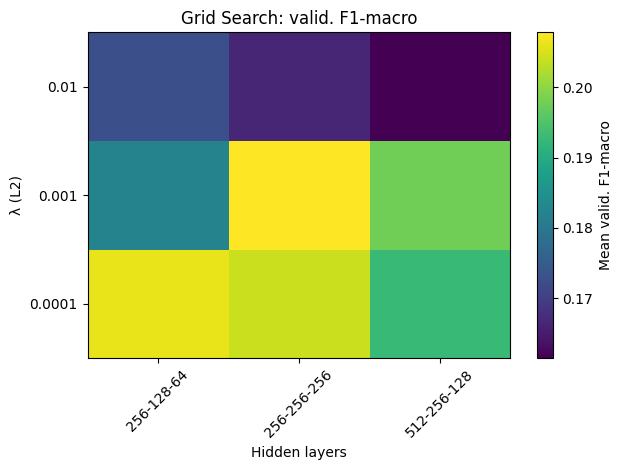

In [51]:
import numpy as np
import matplotlib.pyplot as plt

archs = sorted({k[0] for k in grid_results})
l2s   = sorted({k[1] for k in grid_results})
heat  = np.zeros((len(l2s), len(archs)))

for i, l2 in enumerate(l2s):
    for j, arch in enumerate(archs):
        heat[i, j] = grid_results[(arch, l2)]

plt.imshow(heat, origin='lower', aspect='auto')
plt.colorbar(label='Mean valid. F1-macro')
plt.xticks(np.arange(len(archs)), archs, rotation=45)
plt.yticks(np.arange(len(l2s)), l2s)
plt.xlabel('Hidden layers')
plt.ylabel('λ (L2)')
plt.title('Grid Search: valid. F1-macro')
plt.tight_layout()
plt.show()
